
# Optimized PyTorch Geometric GNN on Ego-Facebook

This notebook refactors and optimizes the provided PyG script into a reproducible training pipeline with engineered graph features, architectural improvements, and training-efficiency techniques.

Update the file path below to point to the `facebook_combined.txt` edge list file before running.


In [1]:

# Paths and basic config
FILE_PATH = 'facebook_combined.txt'  # TODO: set to the dataset path
SAVE_BEST_MODEL_AS = 'optimized_gnn_best.pth'
SEED = 42
EPOCHS = 200
TEST_SIZE = 0.2
HIDDEN_DIM = 32
DROPOUT = 0.5
LEARNING_RATE = 0.005
WEIGHT_DECAY = 1e-4
PATIENCE = 20


In [2]:

import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, BatchNorm
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Reproducibility
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [3]:

# Load graph from edge list
assert isinstance(FILE_PATH, str) and len(FILE_PATH) > 0, 'Please set FILE_PATH to your facebook_combined.txt'
G = nx.read_edgelist(FILE_PATH)
print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Node mapping and convenience items
nodes = list(G.nodes())
node_mapping = {node: idx for idx, node in enumerate(nodes)}
num_nodes = G.number_of_nodes()


Loaded graph with 4039 nodes and 88234 edges


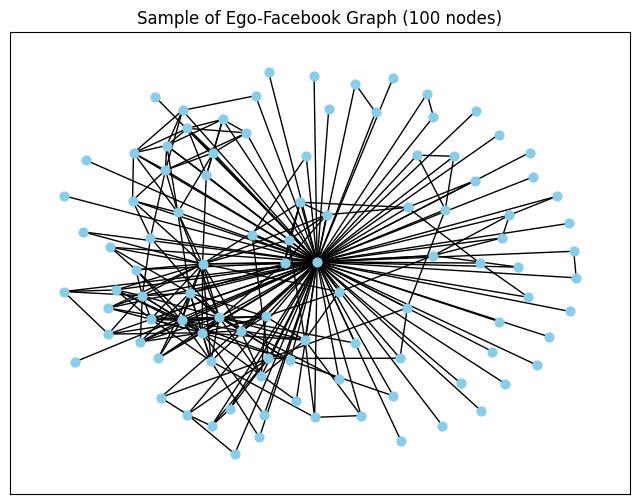

In [4]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Draw a small subgraph for clarity (first 100 nodes)
sub_nodes = nodes[:100]
subgraph = G.subgraph(sub_nodes)

pos = nx.spring_layout(subgraph, seed=SEED)
nx.draw_networkx(subgraph, pos, node_size=40, with_labels=False, node_color='skyblue')
plt.title('Sample of Ego-Facebook Graph (100 nodes)')
plt.show()


In [5]:

# Engineered node features
# Features: normalized degree, clustering coeff, PageRank, betweenness (sampled if large), average neighbor degree

def create_engineered_features(G, nodes):
    degrees = [G.degree(n) for n in nodes]
    max_degree = max(degrees) if degrees else 1
    norm_degrees = [d / max_degree for d in degrees]

    clustering = nx.clustering(G)
    clustering_values = [clustering[n] for n in nodes]

    pagerank = nx.pagerank(G)
    pagerank_values = [pagerank[n] for n in nodes]

    if len(nodes) < 1000:
        betweenness = nx.betweenness_centrality(G)
    else:
        # Sampled betweenness for speed on large graphs
        betweenness = nx.betweenness_centrality(G, k=min(100, max(10, len(nodes)//10)))
    betweenness_values = [betweenness.get(n, 0.0) for n in nodes]

    avg_neighbor_degree = nx.average_neighbor_degree(G)
    avg_neighbor_values = [avg_neighbor_degree[n] for n in nodes]

    X = np.column_stack([
        norm_degrees,
        clustering_values,
        pagerank_values,
        betweenness_values,
        avg_neighbor_values,
    ])

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32)

node_features = create_engineered_features(G, nodes)
print('Feature matrix shape:', tuple(node_features.shape))


Feature matrix shape: (4039, 5)


In [6]:

# Create labels based on degree buckets (Active / Passive / Inactive)
degree_dict = dict(G.degree())
labels = []
for n in nodes:
    d = degree_dict[n]
    if d > 10:
        labels.append(0)  # Active
    elif 1 < d <= 10:
        labels.append(1)  # Passive
    else:
        labels.append(2)  # Inactive
labels = torch.tensor(labels, dtype=torch.long)
print('Labels shape:', tuple(labels.shape), 'num_classes:', int(labels.max().item()+1))


Labels shape: (4039,) num_classes: 3


In [7]:

# Build edge_index (undirected assumed)
edge_index_list = []
for u, v in G.edges():
    edge_index_list.append([node_mapping[u], node_mapping[v]])
    edge_index_list.append([node_mapping[v], node_mapping[u]])  # make edges bidirectional
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
print('edge_index shape:', tuple(edge_index.shape))


edge_index shape: (2, 176468)


In [8]:

# PyG Data object
data = Data(x=node_features, edge_index=edge_index, y=labels)
print(data)


Data(x=[4039, 5], edge_index=[2, 176468], y=[4039])


In [9]:

# Stratified train/test split by label
indices = np.arange(len(labels))
train_idx, test_idx = train_test_split(
    indices, test_size=TEST_SIZE, random_state=SEED, stratify=labels.numpy()
)

# Create boolean masks
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True
data.test_mask[test_idx] = True

print(f"Train nodes: {int(data.train_mask.sum())} | Test nodes: {int(data.test_mask.sum())}")


Train nodes: 3231 | Test nodes: 808


In [10]:

class OptimizedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_classes=3, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim, add_self_loops=False)
        self.bn1 = BatchNorm(hidden_dim)
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = GCNConv(hidden_dim, hidden_dim, add_self_loops=False)
        self.bn2 = BatchNorm(hidden_dim)
        self.drop2 = nn.Dropout(dropout)

        self.conv3 = GCNConv(hidden_dim, num_classes, add_self_loops=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.drop1(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)
        x = self.drop2(x)

        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


In [11]:
input_dim = data.x.size(1)
num_classes = int(labels.max().item() + 1)

# Option A: disable compilation entirely
model = OptimizedGNN(input_dim=input_dim, hidden_dim=HIDDEN_DIM, num_classes=num_classes, dropout=DROPOUT)
print("Running in eager mode (torch.compile disabled)")

# Uncomment the following block to use Option B instead:
# Option B: keep Dynamo tracing but avoid Inductor C++ codegen
# model = torch.compile(OptimizedGNN(input_dim, HIDDEN_DIM, num_classes, DROPOUT), backend="aot_eager", dynamic=True)
# print("Running with backend='aot_eager'")

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = F.nll_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler() if use_amp else None
print('Device:', device)

Running in eager mode (torch.compile disabled)
Device: cpu


In [12]:

def train_step(model, data, optimizer, criterion, scaler=None, use_amp=False):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    if use_amp and scaler is not None:
        with torch.cuda.amp.autocast():
            out = model(data)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    return float(loss.item())

@torch.no_grad()
def evaluate(model, data, use_amp=False):
    model.eval()
    if use_amp:
        with torch.cuda.amp.autocast():
            out = model(data)
    else:
        out = model(data)
    pred = out.argmax(dim=1)
    train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean().item()
    test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()
    return train_acc, test_acc


Epoch 001 | Loss 1.6887 | Train 0.5905 | Test 0.5755
Epoch 002 | Loss 1.4557 | Train 0.6809 | Test 0.6609
Epoch 003 | Loss 1.3631 | Train 0.7474 | Test 0.7376
Epoch 002 | Loss 1.4557 | Train 0.6809 | Test 0.6609
Epoch 003 | Loss 1.3631 | Train 0.7474 | Test 0.7376
Epoch 004 | Loss 1.2293 | Train 0.7546 | Test 0.7450
Epoch 004 | Loss 1.2293 | Train 0.7546 | Test 0.7450
Epoch 005 | Loss 1.1014 | Train 0.7580 | Test 0.7475
Epoch 006 | Loss 1.0059 | Train 0.7642 | Test 0.7624
Epoch 005 | Loss 1.1014 | Train 0.7580 | Test 0.7475
Epoch 006 | Loss 1.0059 | Train 0.7642 | Test 0.7624
Epoch 007 | Loss 0.9313 | Train 0.7629 | Test 0.7636
Epoch 008 | Loss 0.8675 | Train 0.7673 | Test 0.7686
Epoch 009 | Loss 0.8114 | Train 0.7744 | Test 0.7772
Epoch 007 | Loss 0.9313 | Train 0.7629 | Test 0.7636
Epoch 008 | Loss 0.8675 | Train 0.7673 | Test 0.7686
Epoch 009 | Loss 0.8114 | Train 0.7744 | Test 0.7772
Epoch 010 | Loss 0.7535 | Train 0.7756 | Test 0.7822
Epoch 010 | Loss 0.7535 | Train 0.7756 | Test 

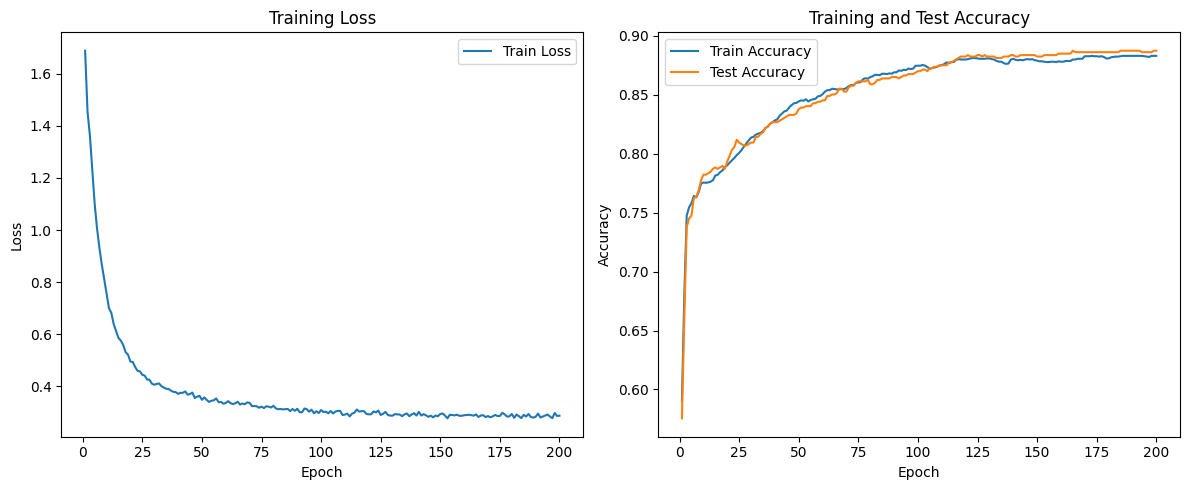

In [13]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, EPOCHS + 1):
    loss = train_step(model, data, optimizer, criterion, scaler, use_amp)
    scheduler.step()

    train_losses.append(loss)
    tr_acc, te_acc = evaluate(model, data, use_amp)
    train_accuracies.append(tr_acc)
    test_accuracies.append(te_acc)

    if epoch % 10 == 0 or epoch <= 10:
        print(f"Epoch {epoch:03d} | Loss {loss:.4f} | Train {tr_acc:.4f} | Test {te_acc:.4f}")

# Serialize the final model at the end of training
final_model_path = 'final_optimized_gnn_with_visualization.pth'
try:
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")
except Exception as e:
    print(f"Failed to save final model: {e}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:

# Class distribution and parameter count
unique, counts = torch.unique(data.y, return_counts=True)
print('Class distribution:')
for lbl, cnt in zip(unique.tolist(), counts.tolist()):
    name = ['Active', 'Passive', 'Inactive'][lbl] if lbl < 3 else str(lbl)
    print(f"  {lbl} ({name}): {cnt} nodes ({cnt/len(data.y)*100:.1f}%)")

n_params = sum(p.numel() for p in model.parameters())
print('Total parameters:', n_params)


Class distribution:
  0 (Active): 3079 nodes (76.2%)
  1 (Passive): 885 nodes (21.9%)
  2 (Inactive): 75 nodes (1.9%)
Total parameters: 1475


## Detailed evaluation metrics

This section adds comprehensive metrics (accuracy, balanced accuracy, F1 scores, Cohen's kappa, MCC), a full classification report, confusion matrices, and optional ROC-AUC (OvR) for multi-class using predicted probabilities. Run these cells after training completes.

Extended metrics (train vs. test):
                     train    test
accuracy            0.8830  0.8874
balanced_accuracy   0.5337  0.5370
matthews_corrcoef   0.6589  0.6721
cohen_kappa         0.6457  0.6578
top2_accuracy       0.9898  0.9901
precision_micro     0.8830  0.8874
recall_micro        0.8830  0.8874
f1_micro            0.8830  0.8874
precision_macro     0.5667  0.5727
recall_macro        0.5337  0.5370
f1_macro            0.5459  0.5501
precision_weighted  0.8614  0.8663
recall_weighted     0.8830  0.8874
f1_weighted         0.8685  0.8728
roc_auc_macro_ovr   0.9737  0.9743
Per-class (test) PRF1:
          precision  recall      f1
Active       0.9018  0.9838  0.9410
Passive      0.8162  0.6271  0.7093
Inactive     0.0000  0.0000  0.0000
Classification report (test):
              precision    recall  f1-score   support

      Active     0.9018    0.9838    0.9410       616
     Passive     0.8162    0.6271    0.7093       177
    Inactive     0.0000    0.0000    0.0000  

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

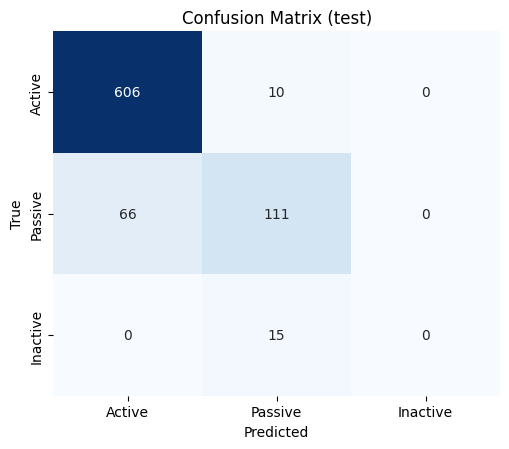

Saved extended_metrics_summary.csv and per_class_metrics_test.csv


In [16]:
# Additional evaluation metrics (train and test)
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    matthews_corrcoef, cohen_kappa_score,
    confusion_matrix, classification_report,
    top_k_accuracy_score, roc_auc_score
)
import pandas as pd

@torch.no_grad()
def _get_outputs_preds(model, data, use_amp=False):
    model.eval()
    if use_amp and torch.cuda.is_available():
        with torch.cuda.amp.autocast():
            out = model(data)
    else:
        out = model(data)
    # out is log-probabilities; convert to probabilities for some metrics
    probs = out.exp().cpu().numpy()
    preds = out.argmax(dim=1).cpu().numpy()
    y_true = data.y.cpu().numpy()
    return y_true, preds, probs

# Collect outputs
y_true_all, y_pred_all, y_proba_all = _get_outputs_preds(model, data, use_amp=use_amp)

train_mask = data.train_mask.cpu().numpy()
test_mask  = data.test_mask.cpu().numpy()

# Slice
y_tr, y_te = y_true_all[train_mask], y_true_all[test_mask]
p_tr, p_te = y_pred_all[train_mask], y_pred_all[test_mask]
pro_tr, pro_te = y_proba_all[train_mask], y_proba_all[test_mask]

labels = np.unique(y_true_all)
num_classes = len(labels)

# Metrics helpers
avg_types = ["micro", "macro", "weighted"]

def compute_pack(y_true, y_pred, y_proba):
    pack = {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "matthews_corrcoef": matthews_corrcoef(y_true, y_pred),
        "cohen_kappa": cohen_kappa_score(y_true, y_pred),
        "top2_accuracy": top_k_accuracy_score(y_true, y_proba, k=min(2, y_proba.shape[1])),
    }
    # macro/micro/weighted PRF1
    for avg in avg_types:
        pack[f"precision_{avg}"] = precision_score(y_true, y_pred, average=avg, zero_division=0)
        pack[f"recall_{avg}"]    = recall_score(y_true, y_pred, average=avg, zero_division=0)
        pack[f"f1_{avg}"]         = f1_score(y_true, y_pred, average=avg, zero_division=0)
    # ROC-AUC (macro OVR) when classes > 1
    try:
        if num_classes > 1:
            pack["roc_auc_macro_ovr"] = roc_auc_score(y_true, y_proba, multi_class="ovr", average="macro")
    except Exception:
        pass
    return pack

train_metrics = compute_pack(y_tr, p_tr, pro_tr)
test_metrics  = compute_pack(y_te, p_te, pro_te)

# Present side-by-side
metrics_df = pd.DataFrame({
    "train": train_metrics,
    "test": test_metrics,
})
print("Extended metrics (train vs. test):")
print(metrics_df.round(4))

# Per-class F1, precision, recall on test
per_cls = pd.DataFrame({
    "precision": precision_score(y_te, p_te, average=None, labels=labels, zero_division=0),
    "recall":    recall_score(y_te, p_te, average=None, labels=labels, zero_division=0),
    "f1":        f1_score(y_te, p_te, average=None, labels=labels, zero_division=0),
}, index=["Active", "Passive", "Inactive"])
print("Per-class (test) PRF1:")
print(per_cls.round(4))

# Classification report (test)
print("Classification report (test):")
print(classification_report(y_te, p_te, target_names=["Active", "Passive", "Inactive"], digits=4))

# Confusion matrix (test)
cm = confusion_matrix(y_te, p_te, labels=labels)

# Try plotting with seaborn if available
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5.2, 4.6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Active", "Passive", "Inactive"],
                yticklabels=["Active", "Passive", "Inactive"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (test)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("[Info] seaborn/matplotlib not available or plotting failed; skipping heatmap.")

# Optionally, save metrics to CSV for reference
metrics_df.round(6).to_csv('extended_metrics_summary.csv')
per_cls.round(6).to_csv('per_class_metrics_test.csv')
print("Saved extended_metrics_summary.csv and per_class_metrics_test.csv")